In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

/Users/adityasingh/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# reading the furnished dataset
data = pd.read_csv("./data/data_clean_in_text.csv")
data.head()

,textID,text,selected_text,sentiment,label
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,-1
2,088c60f138,my boss is bullying me...,bullying me,negative,-1
3,9642c003ef,what interview! leave me alone,leave me alone,negative,-1
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,-1


# Doc2Vec model

In this we will be using Doc2Vec to generate embeddings than rather than using them for recommendation, we will use them for classification using majority vote by the top n similar documents.

## Doc2Vec model for all 3 sentiments

In [3]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec
from sklearn.metrics import accuracy_score

In [4]:
# Create TaggedDocument objects
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i,_d in enumerate(data['text'])]

In [5]:
tagged_data[184]

TaggedDocument(words=['finally', 'got', 'a', 'call', 'for', 'marriage', 'counseling', '3', 'days', 'late', '....'], tags=['184'])

In [6]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=30, min_count=0, epochs=100)

In [7]:
model.build_vocab(tagged_data)

In [8]:
model.train(tagged_data, total_examples=model.corpus_count, epochs=100)

In [9]:
print(data.iloc[7722].text)
print(data.iloc[7722].label)

Happy Star Wars Day. MAY THE 4TH BE WITH YOU
1


In [10]:
similar_doc = model.docvecs.most_similar("7722", topn=5)

In [11]:
def getAllVote(similar_doc, printData = False):
    vote = {}
    for x,y in similar_doc:
        xx = int(x)
        if printData:
            print(f"Document ID: {xx}, Similarity Score: {y}, Label associated: {data.iloc[xx].label}")
        if data.iloc[xx].label not in vote.keys():
            vote[data.iloc[xx].label] = 1
        else:
            vote[data.iloc[xx].label] = vote[data.iloc[xx].label]+1
    return vote

In [12]:
def getMaxVoteLabel(m):
    max_key = max(m, key=m.get)
    return max_key

In [13]:
vote = getAllVote(similar_doc, printData = True)
print(vote)
print(f"Max vote is: {getMaxVoteLabel(vote)}")

Document ID: 8487, Similarity Score: 0.9678317904472351, Label associated: 1
Document ID: 22933, Similarity Score: 0.9676925539970398, Label associated: 0
Document ID: 17187, Similarity Score: 0.9650979042053223, Label associated: 1
Document ID: 18573, Similarity Score: 0.9643941521644592, Label associated: 1
Document ID: 13594, Similarity Score: 0.9632465839385986, Label associated: 1
{1: 4, 0: 1}
Max vote is: 1


### Testing the Doc2Vec model for all 3 sentiments

In [14]:
test_data = pd.read_csv("./data/test.csv")

In [15]:
# Define the mapping
sentiment_mapping = {'positive': 1, 'negative': -1, 'neutral': 0}

# Map the values and create a new column
test_data['label'] = test_data['sentiment'].map(sentiment_mapping)

In [16]:
test_data

,textID,text,sentiment,label
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,1
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,-1
3,01082688c6,happy bday!,positive,1
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,1
...,...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",negative,-1
3530,416863ce47,All alone in this old house again. Thanks for...,positive,1
3531,6332da480c,I know what you mean. My little dog is sinkin...,negative,-1
3532,df1baec676,_sutra what is your next youtube video gonna b...,positive,1


In [17]:
def getLabelByVoting(x):
    text = word_tokenize(x.lower())
    vector = model.infer_vector(text)
    similar_doc_tags = model.docvecs.similar_by_vector(vector, topn=5)
    vote = getAllVote(similar_doc_tags)
    return getMaxVoteLabel(vote)

In [18]:
actual = test_data.label
predictions = test_data.text.apply(getLabelByVoting)

In [19]:
accuracy_score(actual, predictions)

0.4663271080928127

## Doc2Vec model for only positive and negative sentiments

In [20]:
data_pos_neg = data[data.label != 0]

In [21]:
# Create TaggedDocument objects
tagged_data_pos_neg = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i,_d in enumerate(data_pos_neg['text'])]

In [22]:
tagged_data_pos_neg[184]

TaggedDocument(words=['before', 'i', 'get', 'too', 'distracted', ',', 'i', '`', 'd', 'like', 'to', 'thank', 'my', 'new', 'followers', 'for', 'taking', 'the', 'trouble', 'to', 'follow', 'me', '!', 'and', 'to', 'my', 'others', ':', 'feelin', 'the', 'love'], tags=['184'])

In [132]:
model_pos_neg = gensim.models.doc2vec.Doc2Vec(vector_size=20, min_count=0, epochs=100)

In [133]:
model_pos_neg.build_vocab(tagged_data_pos_neg)

In [134]:
model_pos_neg.train(tagged_data_pos_neg, total_examples=model_pos_neg.corpus_count, epochs=100)

In [135]:
print(data_pos_neg.iloc[7722].text)
print(data_pos_neg.iloc[7722].label)

Refusing to accept that the US holiday is over. Heading to Woodies Longboard  Diner in um ... Hove...
-1


In [136]:
similar_doc_pos_neg = model_pos_neg.docvecs.most_similar("7722", topn=1)

In [137]:
def getAllVote_pos_neg(similar_doc, printData = False):
    vote = {}
    for x,y in similar_doc:
        xx = int(x)
        if printData:
            print(f"Document ID: {xx}, Similarity Score: {y}, Label associated: {data_pos_neg.iloc[xx].label}")
        if data_pos_neg.iloc[xx].label not in vote.keys():
            vote[data_pos_neg.iloc[xx].label] = 1
        else:
            vote[data_pos_neg.iloc[xx].label] = vote[data_pos_neg.iloc[xx].label]+1
    return vote

In [138]:
def getMaxVoteLabel_pos_neg(m):
    max_key = max(m, key=m.get)
    return max_key

In [139]:
vote_pos_neg = getAllVote_pos_neg(similar_doc_pos_neg, printData = True)
print(vote_pos_neg)
print(f"Max vote is: {getMaxVoteLabel_pos_neg(vote_pos_neg)}")

Document ID: 6385, Similarity Score: 0.8475138545036316, Label associated: -1
{-1: 1}
Max vote is: -1


### Testing the Doc2Vec model

In [140]:
test_data_pos_neg = pd.read_csv("./data/test.csv")

In [141]:
# Define the mapping
sentiment_mapping = {'positive': 1, 'negative': -1, 'neutral': 0}

# Map the values and create a new column
test_data_pos_neg['label'] = test_data_pos_neg['sentiment'].map(sentiment_mapping)
test_data_pos_neg = test_data_pos_neg[test_data_pos_neg.label != 0]

In [142]:
test_data_pos_neg

,textID,text,sentiment,label
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,1
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,-1
3,01082688c6,happy bday!,positive,1
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,1
5,726e501993,that`s great!! weee!! visitors!,positive,1
...,...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",negative,-1
3530,416863ce47,All alone in this old house again. Thanks for...,positive,1
3531,6332da480c,I know what you mean. My little dog is sinkin...,negative,-1
3532,df1baec676,_sutra what is your next youtube video gonna b...,positive,1


In [143]:
def getLabelByVoting_pos_neg(x):
    text = word_tokenize(x.lower())
    vector = model.infer_vector(text)
    similar_doc_tags = model.docvecs.similar_by_vector(vector, topn=5)
    vote = getAllVote_pos_neg(similar_doc_tags)
    return getMaxVoteLabel_pos_neg(vote)

In [144]:
actual_pos_neg = test_data_pos_neg.label
predictions_pos_neg = test_data_pos_neg.text.apply(getLabelByVoting)

In [145]:
accuracy_score(actual_pos_neg, predictions_pos_neg)

0.4344106463878327

### Conclusion

As we can see from the result, the accuracy is not too good for both the cases.

Accuracy for all 3 sentiments: `47.198641765704585%`

Accuracy for only positive and negative sentiments: `43.155893536121676%`

# Applying legacy machine learning Algorithm using the embeddings

In [181]:
from sklearn.preprocessing import StandardScaler

In [169]:
data['embeddings'] = [model.infer_vector(tagged_data[i][0]) for i in range(data.shape[0])]

In [170]:
data.head(3)

,textID,text,selected_text,sentiment,label,embeddings
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,0,"[-0.29866812, 0.14685397, 0.4986472, 0.5574105..."
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,-1,"[0.6388572, 1.1707686, 0.6398802, 0.038445663,..."
2,088c60f138,my boss is bullying me...,bullying me,negative,-1,"[-0.07458924, -0.0923644, 0.28021705, 0.082168..."


In [171]:
test_data['embeddings'] = [model.infer_vector(word_tokenize(test_data.iloc[i].text.lower())) for i in range(test_data.shape[0])]

In [172]:
test_data.head(3)

,textID,text,sentiment,label,embeddings
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,0,"[0.46594217, -0.4546303, 0.116197415, -0.56624..."
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,1,"[-1.7790568, 0.7968681, 0.720967, -1.5281974, ..."
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,-1,"[-0.00635587, -1.3990024, -0.67200416, -0.4491..."


In [173]:
X = [data.iloc[i].embeddings for i in range(data.shape[0])]

In [183]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [184]:
X_test = [test_data.iloc[i].embeddings for i in range(test_data.shape[0])]
X_test = scaler.fit_transform(X_test)

## KNN

In [185]:
from sklearn.neighbors import KNeighborsClassifier

In [197]:
neighbours = []
accuracy = []
for i in range(1,40):
    neighbours.append(i)
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X, data.label)
    predictions = knn.predict(X_test)
    accuracy.append(accuracy_score(test_data.label, predictions)*100)
    print(f"Done for n_neighbours: {i}")

Done for n_neighbours: 1
Done for n_neighbours: 2
Done for n_neighbours: 3
Done for n_neighbours: 4
Done for n_neighbours: 5
Done for n_neighbours: 6
Done for n_neighbours: 7
Done for n_neighbours: 8
Done for n_neighbours: 9
Done for n_neighbours: 10
Done for n_neighbours: 11
Done for n_neighbours: 12
Done for n_neighbours: 13
Done for n_neighbours: 14
Done for n_neighbours: 15
Done for n_neighbours: 16
Done for n_neighbours: 17
Done for n_neighbours: 18
Done for n_neighbours: 19
Done for n_neighbours: 20
Done for n_neighbours: 21
Done for n_neighbours: 22
Done for n_neighbours: 23
Done for n_neighbours: 24
Done for n_neighbours: 25
Done for n_neighbours: 26
Done for n_neighbours: 27
Done for n_neighbours: 28
Done for n_neighbours: 29
Done for n_neighbours: 30
Done for n_neighbours: 31
Done for n_neighbours: 32
Done for n_neighbours: 33
Done for n_neighbours: 34
Done for n_neighbours: 35
Done for n_neighbours: 36
Done for n_neighbours: 37
Done for n_neighbours: 38
Done for n_neighbours

The best accuracy achieved is 50.22637238256933 for # of neighbours: 33


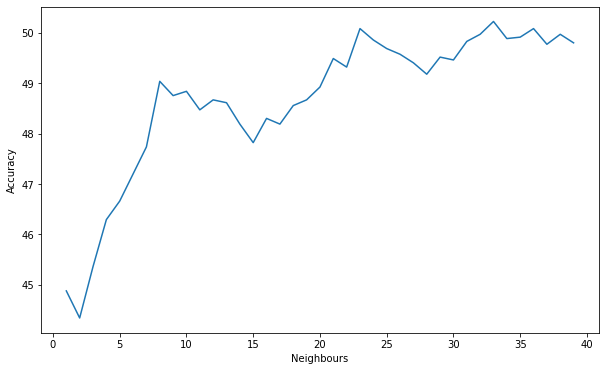

In [208]:
print(f"The best accuracy achieved is {max(accuracy)} for # of neighbours: {np.argmax(accuracy)+1}")
plt.figure(figsize = (10,6))
sns.lineplot(x=neighbours, y=accuracy)
plt.xlabel("Neighbours")
plt.ylabel("Accuracy")
plt.show()

The accuracy achieved by the KNN is better than just using embeddings. Although the difference is not much. The best accuracy is `50.22637238256933%`